<a href="https://colab.research.google.com/github/kavyajeetbora/metro_accessibility/blob/master/notebooks/ETL_OSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q osmnx
!pip install -q pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.2 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
import time
import warnings
warnings.filterwarnings('ignore')

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

Deploy Flask apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


## Setup duckdb

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [6]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


## Download OSM data

In [7]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

## Select city
city = "Mumbai"
W,S,E,N = bboxs[city]

Download all the station nodes:

In [8]:
%%time

public_transport = ox.features.features_from_bbox(
    bbox=(N,S,E,W),
    tags={
        'railway': ['stop', 'station'],
        'subway':True
        }
).reset_index()

## Extract the station data:
pb = public_transport[public_transport['element_type']=='node'].copy()
columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'network', 'operator', 'public_transport',
       'ref', 'train','subway','station']

pb_gdf = pb[columns]
pb_gdf = pb_gdf.fillna('None')
# metro_stations = pb_gdf[pb_gdf['network'].str.lower().str.contains('metro')]
print("Total nodes with station tag:",pb_gdf.shape[0])
pb_gdf.sample(min(5,len(pb_gdf)))

Total nodes with station tag: 573
CPU times: user 426 ms, sys: 22.1 ms, total: 448 ms
Wall time: 2.16 s


,element_type,osmid,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
501,node,9630642180,POINT (72.86599 19.25724),stop,None,Anand Nagar (Dahisar),Mumbai Metro,MMRDA,stop_position,None,None,yes,None
26,node,619290482,POINT (72.84428 18.96643),stop,None,Dockyard Road,None,None,stop_position,None,yes,None,None
502,node,9630642181,POINT (72.86600 19.25729),stop,None,Anand Nagar (Dahisar),Mumbai Metro,MMRDA,stop_position,None,None,yes,None
196,node,3389150483,POINT (72.85698 19.11556),stop,None,Western Express Highway,Mumbai Metro,MMRDA,stop_position,None,None,yes,None
264,node,5219622877,POINT (72.83565 19.15302),stop,None,Goregaon West,None,None,stop_position,None,None,yes,None


In [10]:
pb_gdf['station'].value_counts()

station
None          510
subway         44
monorail       17
light_rail      1
terminal        1
Name: count, dtype: int64

In [11]:
pb_gdf['subway'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


subway
None    390
yes     183
Name: count, dtype: int64

<Axes: >

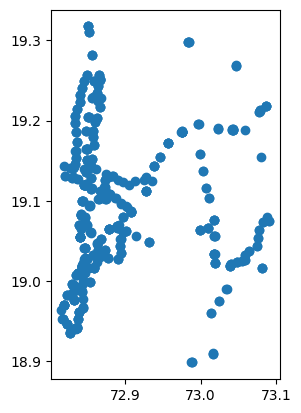

In [37]:
pb_gdf.plot()

### Filter the public transport nodes

in this study, we want only the subway lines including the monorail

In [65]:
condition = ((pb_gdf['subway']=='yes') | (pb_gdf['station']=='monorail')) & (pb_gdf['railway']!='construction')
metro_stations = pb_gdf.loc[condition]
metro_stations = metro_stations.drop(['osmid','element_type'], axis=1)
print("Total stations found", metro_stations.shape[0])
metro_stations.sample(3)

Total stations found 186


,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
290,POINT (73.07434 19.04323),stop,None,Sector 14,None,None,stop_position,None,None,yes,None
534,POINT (72.83581 19.18529),station,None,Malad West,None,None,station,None,None,yes,subway
220,POINT (72.84331 18.99451),station,None,Mint Colony,None,None,platform,None,None,None,monorail


In [66]:
metro_stations.to_file(f'{city}_stations_stops.gpkg', driver='GPKG')

## Buffered Stations

Station nodes in OSM maynot be labelled with correct tags, so this may required evaluation before processing.



In [67]:
buffered_stations = metro_stations.copy()
buffered_stations = buffered_stations.to_crs('EPSG:32643')
buffered_stations['geometry'] = buffered_stations['geometry'].buffer(10)
buffered_stations = buffered_stations.to_crs("EPSG:4326")
buffered_stations.head(2)

,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
37,"POLYGON ((72.84813 19.12092, 72.84813 19.12091...",stop,None,Andheri,Mumbai Metro,MMRDA,stop_position,None,None,yes,None
38,"POLYGON ((72.83091 19.12818, 72.83091 19.12817...",stop,None,D. N. Nagar,Mumbai Metro,MMRDA,stop_position,None,None,yes,None


In [68]:
buffered_stations.to_parquet('stations-buffered.parquet')
buffered_stations.geometry.geom_type.unique()

array(['Polygon'], dtype=object)

## Download Station Buildings

Downloading the buildings from overturemaps using duckdb

The overture map's data keeps on updating month on month. Refer to the release notes to download the latest data: [lastest releases](https://docs.overturemaps.org/release/latest/)

[Download Overture Maps Data](https://overturemaps.org/download/)



In [75]:
%%time

buildings_data_url = r"'s3://overturemaps-us-west-2/release/2024-07-22.0/theme=buildings/type=*/*'"
stations_data_url = "'stations-buffered.parquet'"

df = duckdb.sql(
    f'''
    LOAD spatial;
    LOAD httpfs;
    COPY(
        SELECT
            id,
            names.primary as name,
            buildings.height as height,
            stations.name as station_name,
            stations.network as network,
            stations.operator as operator,
            stations.railway as railway,
            stations.subway as subway,
            stations.station as station,
            ST_GeomFromWKB(buildings.geometry) as geom
        FROM read_parquet({buildings_data_url}, filename=true, hive_partitioning=1) AS buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Intersects(ST_GeomFromWKB(buildings.geometry), ST_GeomFromWKB(stations.geometry))
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO '{city}_station_buildings_v1.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
   '''
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 15.9 s, sys: 1.42 s, total: 17.3 s
Wall time: 3min 33s


In [82]:
sbf = gpd.read_file(f'{city}_station_buildings.geojson').drop_duplicates('geometry')  ## Unique Building footprints
print('Stations with enclosing buildings:', sbf.shape[0])
sbf['source'] = 'Overture Maps'
sbf.to_file(f'{city}_station_buildings.geojson', driver='GeoJSON')
sbf.sample(5)

Stations with enclosing buildings: 103


,height,station_name,network,operator,railway,subway,station,source,geometry
86,None,Bharat Petroleum,None,None,station,None,monorail,Overture Maps,"POLYGON ((72.89578 19.03500, 72.89556 19.03564..."
6,None,Eksar,Mumbai Metro,MMRDA,stop,yes,None,Overture Maps,"POLYGON ((72.84273 19.23979, 72.84293 19.23962..."
18,None,Kurar Village,None,None,station,yes,subway,Overture Maps,"POLYGON ((72.85835 19.18803, 72.85837 19.18634..."
66,None,Ghatkopar,Mumbai Metro,MMRDA,stop,yes,None,Overture Maps,"POLYGON ((72.90811 19.08752, 72.90806 19.08752..."
7,None,Rashtriya Udyan,Mumbai Metro,MMRDA,station,yes,subway,Overture Maps,"POLYGON ((72.86301 19.23555, 72.86303 19.23384..."


This will give all the building footprints surrounding the station nodes.
Note that buildings are based on overture maps which is not so well updated. There might me some stations without a enclosing building footprint

Let's find out those stations:

In [58]:
# if sbf['id'].isna().sum()>0:
#     no_bf = stations[stations[['geometry']].reset_index(drop=True).sjoin(sbf.reset_index(drop=True), how='left', predicate='intersects').id.isna()].copy()
#     print('Stations without enclosing buildings:', no_bf.shape[0])

#     no_bf.to_file('stations_wo_BF.gpkg', driver='GPKG')
#     no_bf.to_parquet("stations_wo_BF.parquet")

# else:
#     no_bf = None

## Download building footprints from VIDA


[Google-Microsoft Open Buildings - combined by VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/):

This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. With 2,534,595,270 footprints, it is to our knowledge the most complete openly available dataset as of Sep. 2023. It covers 92% of Level 0 administrative boundaries, and is divided into 182 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles



Load the building polygons

In [20]:
# %%time
# stations_data_url = "'stations_stops.parquet'"
# prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
# partitions = "by_country"
# country_iso = "IND"

# duckdb.sql(f'''
# describe FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' AS buildings
# ''')

In [21]:
# if no_bf is not None:

#     start_time = time.time()

#     stations_data_url = "'stations_stops.parquet'"
#     prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
#     partitions = "by_country"
#     country_iso = "IND"

#     query = f'''
#     COPY(
#         SELECT
#         ST_Xmin(ST_GeomFromWKB(buildings.geometry)) as xmin,
#         ST_Xmax(ST_GeomFromWKB(buildings.geometry)) as xmax,
#         ST_Ymin(ST_GeomFromWKB(buildings.geometry)) as ymin,
#         ST_Ymax(ST_GeomFromWKB(buildings.geometry)) as ymax,
#         confidence,
#         bf_source,
#         ST_GeomFromWKB(buildings.geometry)
#         FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
#         JOIN read_parquet({stations_data_url}) as stations
#         ON ST_Within(ST_GeomFromWKB(stations.geometry), ST_GeomFromWKB(buildings.geometry))
#         WHERE xmin > {W}
#         AND xmax < {E}
#         AND ymin > {S}
#         AND ymax < {N}
#     ) TO 'ML_station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
#     '''

#     duckdb.sql(query)

#     end_time = (time.time()-start_time)/60

#     print(f"Time taken to process the request: {end_time:2f} mins")

In [22]:
# gdf = gpd.read_file('ML_station_buildings.geojson')
# print(gdf.shape)

In [23]:
# gdf.sample(5)

In [24]:
# gpd.read_parquet('stations_stops.parquet')

## Download the public transport routes

In [78]:
%%time

public_transport_routes = ox.features.features_from_bbox(
    bbox=(N,S,E,W),
    tags={
        'railway': ['subway','monorail'],
        }
).reset_index()

## Extract the station data:
routes = public_transport_routes[public_transport_routes['element_type']=='way'].copy()
route_columns = ['name', 'railway','network', 'operator','source','start_date','geometry']

route_gdf = routes[route_columns]
route_gdf = route_gdf.fillna('None')
print("Total ways with rail tag:",route_gdf.shape[0])
route_gdf.sample(min(5,len(route_gdf)))

<timed exec>:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.


Total ways with rail tag: 229
CPU times: user 548 ms, sys: 5.02 ms, total: 553 ms
Wall time: 1.7 s


,name,railway,network,operator,source,start_date,geometry
107,None,subway,None,None,None,2023-11-17,"LINESTRING (73.08797 19.08169, 73.08790 19.082..."
103,Navi Mumbai Metro Line 1,subway,None,None,None,2023-11-17,"LINESTRING (73.04211 19.02164, 73.04230 19.021..."
129,None,subway,None,None,None,2022-04-02,"LINESTRING (72.82256 19.19984, 72.82431 19.199..."
27,None,monorail,None,None,None,None,"LINESTRING (72.87487 19.03932, 72.87489 19.03844)"
47,Line 7,subway,Mumbai Metro,MMRDA,None,2022-04-02,"LINESTRING (72.85874 19.16955, 72.85882 19.170..."


<Axes: >

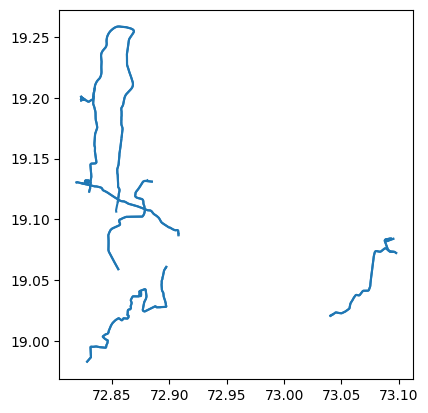

In [79]:
route_gdf.plot()

In [80]:
route_gdf.to_file(f"{city}_public_transport_route.geojson", driver='GeoJSON')